<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [6]:
import datetime as dt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [3]:
from process_meteo_drivers import grab_meteo_data
from concurrent.futures import ThreadPoolExecutor
from functools import partial
meteo_folder = "/data/geospatial_08/ucfajlg/ERA5_meteo"
meteo_files = []
wrapper = lambda year: grab_meteo_data(
        9.2,
        -0.9,
        year,
        f"era5_africa_{year:d}.nc",
        meteo_folder,
        site_name="Ghana")
# create a thread pool of 10 threads

years = np.arange(2010,2019).astype(np.int)
with ThreadPoolExecutor(max_workers=1) as executor:
    for _ in executor.map(wrapper, years):
        pass



/opt/anaconda/envs/jupyterhub/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


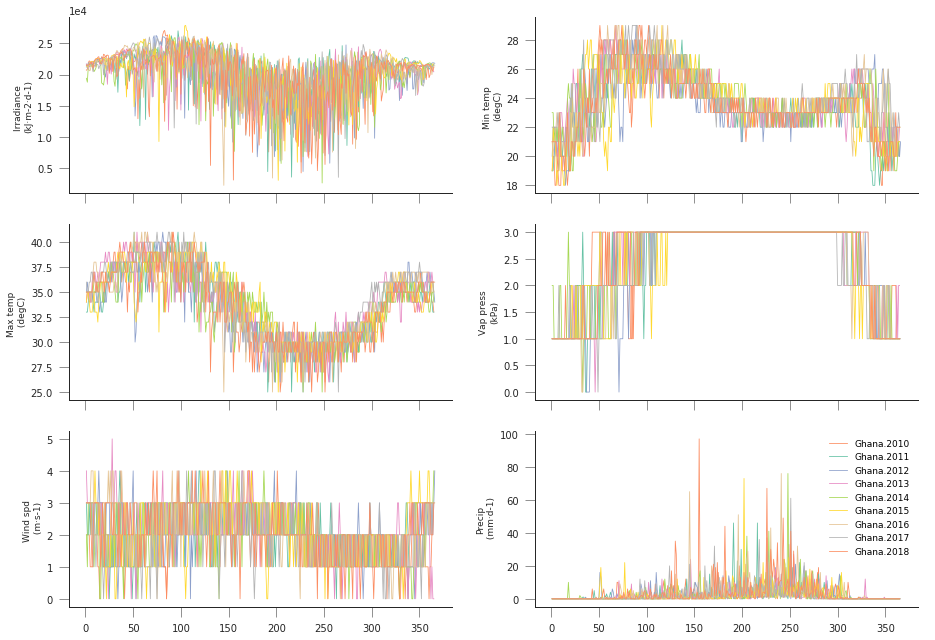

In [19]:
def plot_meteo(meteo):
    parameters = ["Irradiance \n(kJ·m-2·d-1)",
     "Min temp \n(degC)",
    "Max temp \n (degC)",
    "Vap press\n(kPa)",
    "Wind spd \n (m·s-1)",
    "Precip\n (mm·d-1)"]
    if type(meteo) != type([]): meteo = [meteo]
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13,9), sharex=True,squeeze=True)
    axs = axs.flatten()
    for meteo_file in meteo:
        d = np.loadtxt(meteo_file.as_posix(), skiprows=20)
        for i,p in enumerate(parameters):
            if i == 5:
                axs[i].plot(d[:,2], d[:,3+i], '-', lw=0.8, label=meteo_file.name)
            else:
                axs[i].plot(d[:,2], d[:,3+i], '-', lw=0.8)
            axs[i].set_ylabel(p, fontsize=9)
    axs[-1].legend(loc="best", frameon=False, fontsize=9)
    fig.tight_layout()
meteo_files = sorted([f for f in Path.cwd().glob("Ghana.20??")])
plot_meteo(meteo_files)

In [45]:
precip = []
for meteo_file in meteo_files:
    year = int(meteo_file.name.split(".")[-1])
    print(year)
    d = np.loadtxt(meteo_file.as_posix(), skiprows=20)
    doy = [dt.datetime(year, 1, 1) +dt.timedelta(days=int(j)) for j in d[:,2]
          ]
    precip.append(np.c_[doy, d[:,8]])


2010
2011
2012
2013
2014
2015
2016
2017
2018


In [ ]:
rr = []
for i, year in enumerate(range(2010, 2019)):
    sowing = dt.datetime(year, 5, 20)
    harvesting = dt.datetime(year, 9, 10)
    p = precip[i]
    passer = np.logical_and(p[:, 0] >= sowing,
                            p[:,0] <= harvesting)
    rr.append([year, p[passer, 1].sum()])

plt.plot(rr)

/opt/anaconda/envs/jupyterhub/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)


from traitlets import link
import ipywidgets as widgets

#center = [-12.543839666237682, 131.08474731445315]
center =[-20.0183,145.3134]
zoom = 10


m = Map(center=center, zoom=zoom,layout=dict(width='400px', height='400px'))

#Let's draw a second map

m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


# Now create the DrawControls and add it to the Maps using add_control.
# We also register handlers for draw events. These will fire when a polygon is drawn created, edited or deleted
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path,
# along with its embedded style.

draw_control = DrawControl(polyline={})
draw_control2 = DrawControl(polygon={'shapeOptions': {'color': '#0000FF'}}, polyline={})
def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):

    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])

#add handlers to draw controls
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

#use_map_geom_button = widgets.Button(description="Use Drawn Geom")

use_map_geom_button = widgets.ToggleButtons(
    options=['Shapefile', 'DrawnPolygon'],
    description='Geometry Used for Datacube Query:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Use Shapefile Specified for the DC query', 'Use Polygon Drawn on the Map for the DC query'],
#     icons=['check'] * 3
)

def on_map_button_click(b):
    global GEOM
    global SHAPE_NAME
    #Leaflet return geometry in EPSG:4326
    geom_crs = geometry.CRS('EPSG:4326')
    if use_map_geom_button.value == "Shapefile":
        GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file_text.value)
    else:
        try:
            GEOM=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
            SHAPE_NAME = "drawn_polygon"
        except:
            print("Draw a polygon first.")

use_map_geom_button.on_trait_change(on_map_button_click)


from ipywidgets import HBox, VBox
h_box= HBox([m,m2])

VBox([h_box,use_map_geom_button])

/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:89: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
